# Preliminary

The purpose of preliminaries is to use historical data to detect a profitable pattern

In [1]:
import pandas as pd

from utils.read2df import read2df, unify_dfs

symbols = ['BTCUSDT', 'ETHUSDT']
freqs = {'3m': 3, '5m':5}
period = 1000

date_format = '%Y-%m-%d'
start_date = '2023-01-01'
end_date = '2023-12-31'

In [2]:
%%capture
if symbols is None:
    !python binance-public-data/python/download-kline.py \
        -i {" ".join(list(freqs.keys()))} -startDate {start_date} -endDate {end_date} -t spot -skip-daily 1
else:
    !python binance-public-data/python/download-kline.py \
        -s {" ".join(symbols)} -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1

In [3]:
dfs = read2df(symbols=symbols, freqs={'3m': 3}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=symbols, period=period)

In [4]:
df.iloc[2000:3000:100]

,index,time,close0,itvl,datetime,close1,spread,zscore
2000,2000,1672891379999,16826.60,3m,2023-01-05 04:02:59.999,1253.25,-22.681038,-0.446050
2100,2100,1672909379999,16805.39,3m,2023-01-05 09:02:59.999,1249.80,-26.840315,-0.619306
2200,2200,1672927379999,16777.06,3m,2023-01-05 14:02:59.999,1247.16,-40.056583,-1.219891
2300,2300,1672945379999,16844.09,3m,2023-01-05 19:02:59.999,1251.55,8.160032,1.290822
2400,2400,1672963379999,16829.52,3m,2023-01-06 00:02:59.999,1250.87,-4.148572,0.482245
2500,2500,1672981379999,16818.06,3m,2023-01-06 05:02:59.999,1249.54,-6.927411,0.202757
2600,2600,1672999379999,16785.82,3m,2023-01-06 10:02:59.999,1248.08,-21.412092,-0.610330
2700,2700,1673017379999,16775.41,3m,2023-01-06 15:02:59.999,1250.70,-42.401863,-1.672495
2800,2800,1673035379999,16963.32,3m,2023-01-06 20:02:59.999,1273.39,42.149267,2.521667
2900,2900,1673053379999,16979.80,3m,2023-01-07 01:02:59.999,1270.90,45.184720,2.021860


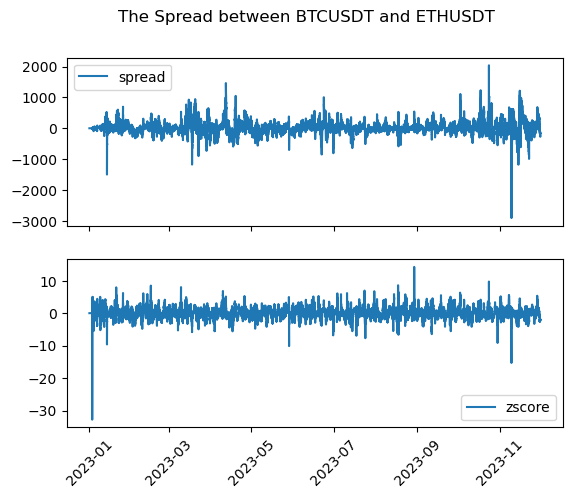

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {symbols[0]} and {symbols[1]}')

plt.xticks(rotation=45)
plt.show()

In [26]:
from tqdm import trange

cash = 10000
position, holdings = 0, [0, 0]
open_thre, clos_thre = 2, 0.1
tc = 0.001
next_pos = 0

for i in trange(len(df)):
    price0 = df.iloc[i]['close0']
    price1 = df.iloc[i]['close1']
    max_unit0 = cash/price0
    max_unit1 = cash/price1

    if position==0 and df.iloc[i]['zscore']>=open_thre:
        holdings = [max_unit0*(1-tc), -max_unit1*(1-tc)]
        next_pos = -1
    elif position==0 and df.iloc[i]['zscore']<=-open_thre:
        holdings = [-max_unit0*(1-tc), max_unit1*(1-tc)]
        next_pos = 1
    elif position==-1 and df.iloc[i]['zscore']<=clos_thre:
        cash += (holdings[0] * price0 + holdings[1] * price1) * (1-tc)
        holdings = [0, 0]
        next_pos = 0
    elif position==1 and df.iloc[i]['zscore']>=-clos_thre:
        cash += (holdings[0] * price0 + holdings[1] * price1) * (1-tc)
        holdings = [0, 0]
        next_pos = 0

    position = next_pos

networth = cash + holdings[0] * price0 + holdings[1] * price1
print(f"networth: {networth}")

100%|██████████| 160293/160293 [00:11<00:00, 13779.87it/s]

networth: 14231.322928639473
